In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from pandas.plotting import parallel_coordinates
from scipy.cluster import hierarchy
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA


In [2]:
InteractiveShell.ast_node_interactivity = "all"


In [3]:
# Design

# Sizes

title_size = 50
tick_size = 30
text_size = 30

# Colors

palette_max_5 = {
    0: '#fbb61a',
    1: '#ed6925',
    2: '#ba3655',
    3: '#781c6d',
    4: '#320a5e'
}

sns.color_palette('inferno_r', 5)


[(0.986175, 0.713153, 0.103863),
 (0.929644, 0.411479, 0.145367),
 (0.729909, 0.212759, 0.333861),
 (0.472328, 0.110547, 0.428334),
 (0.197297, 0.0384, 0.367535)]

In [4]:
# Functions


def plot_correlation_circle(pc1, pc2, columns, pc1_name, pc2_name):

    """Plots the correlation circle of given principal components"""

    fig, ax = plt.subplots(figsize=(12, 12))

    for i, (x, y) in enumerate(zip(pc1, pc2)):

        plt.plot([0, x], [0, y], color='k', alpha=0.5)
        plt.text(x, y, columns[i], fontsize='14')

    ax.add_patch(plt.Circle((0, 0), 1,
                            fill = False,
                            color=sns.color_palette('icefire')[0]))

    ax.plot([-1, 1], [0, 0], color=sns.color_palette('icefire')[0], ls='--')
    ax.plot([0, 0], [-1, 1], color=sns.color_palette('icefire')[0], ls='--')

    ax.set_xlabel('{}'.format(pc1_name), fontsize=text_size)
    ax.set_ylabel('{}'.format(pc2_name), fontsize=text_size)

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])

    ax.tick_params(labelsize=tick_size)

    plt.title('Principal Component Circle', fontsize=title_size, pad=30)

    plt.show();


In [5]:
# Imports dataframe

cleaned_df = \
    pd.read_csv(r'F:\Data\Projet 5\Livrables\cleaned_data')

# Seed for random states

seed = 34

# RFM

rfm_selection = [
    'Frequency',
    'Recency',
    'Monetary_Sum']

# Creates X dataframe for modelings on RFM

X = cleaned_df[rfm_selection].copy()

X.head()


,Frequency,Recency,Monetary_Sum
0,1,-1426,141.90
1,1,-1429,27.19
2,1,-1852,86.22
3,1,-1636,43.62
4,1,-1603,196.89


<center><h6>Preprocessing

In [6]:
# Reciproqual transformation for left skewed distributions

X['Recency'] = 1/(-X[['Recency']])

# Logarithmic transformation for right skewed distributions

X[['Frequency', 'Monetary_Sum']] = np.log1p(X[['Frequency', 'Monetary_Sum']])

# StandardScale the data

X_std = StandardScaler().fit_transform(X)

X_std = pd.DataFrame(data=X_std, columns=X.columns)


<center><h6>Dimensionality Reduction (for visualisation only)

In [7]:
# PCA on max number of components

X_std_pca = PCA(n_components=3).fit(X_std[rfm_selection])

# Computes the projection of the data in a new dataframe

X_std_pca_projected = pd.DataFrame(X_std_pca.transform(X_std[rfm_selection]))

X_std_pca_projected = \
    X_std_pca_projected.rename({0: 'PC1', 1: 'PC2', 2: 'PC3'}, axis=1)

components_name = X_std_pca_projected.columns.tolist()

X_std_pca_projected.head()


,PC1,PC2,PC3
0,0.197129,-0.788423,-0.355880
1,-1.209626,-1.016255,1.060957
2,-0.588923,1.703327,0.174536
3,-1.009719,0.464546,0.715126
4,0.306218,0.494785,-0.591997


In [8]:
# Creates a dataframe to analyse the explained variace of the above PCA

X_std_pca_df = \
    pd.DataFrame(data=np.c_[X_std_pca.explained_variance_ratio_,
                            np.cumsum(X_std_pca.explained_variance_ratio_)],
                 columns=['Explained_variance',
                          'Cumulative_explained_variance'])

X_std_pca_df


,Explained_variance,Cumulative_explained_variance
0,0.388810,0.388810
1,0.332330,0.721141
2,0.278859,1.000000


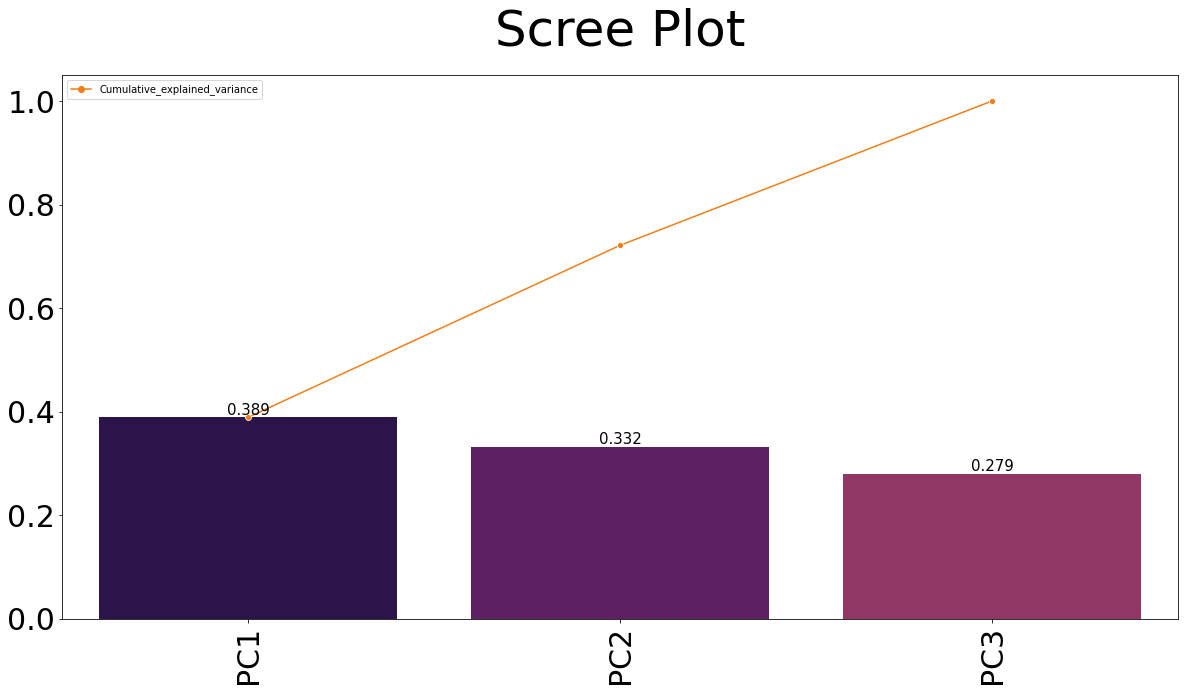

In [9]:
# Plots the PCA's scree plot

fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(data=X_std_pca_df[['Cumulative_explained_variance']],
             markers=True,
             palette=[sns.color_palette("inferno")[4]])

sns.barplot(data=X_std_pca_df[['Explained_variance']].T,
            palette=sns.color_palette('inferno', 6),
            ax=ax)

ax.set_xticklabels(['PC' + str(i + 1) for i in range(X_std_pca_df.shape[0])],
                   rotation=90)

ax.bar_label(
    ax.containers[0],
    fmt='%.3f',
    **{'size': 15})

ax.legend(loc='upper left')
ax.tick_params(labelsize=tick_size)
plt.title('Scree Plot', fontsize=title_size, pad=30)
plt.show();


<p class="anchor" id="PCA_Circles"></p>

* [Anchor to Kmeans's PCA ](#PCA_Kmeans)
* [Anchor to DBSCAN's PCA ](#PCA_DBSCAN)
* [Anchor to Hierarchcal's PCA ](#PCA_hierarchical)

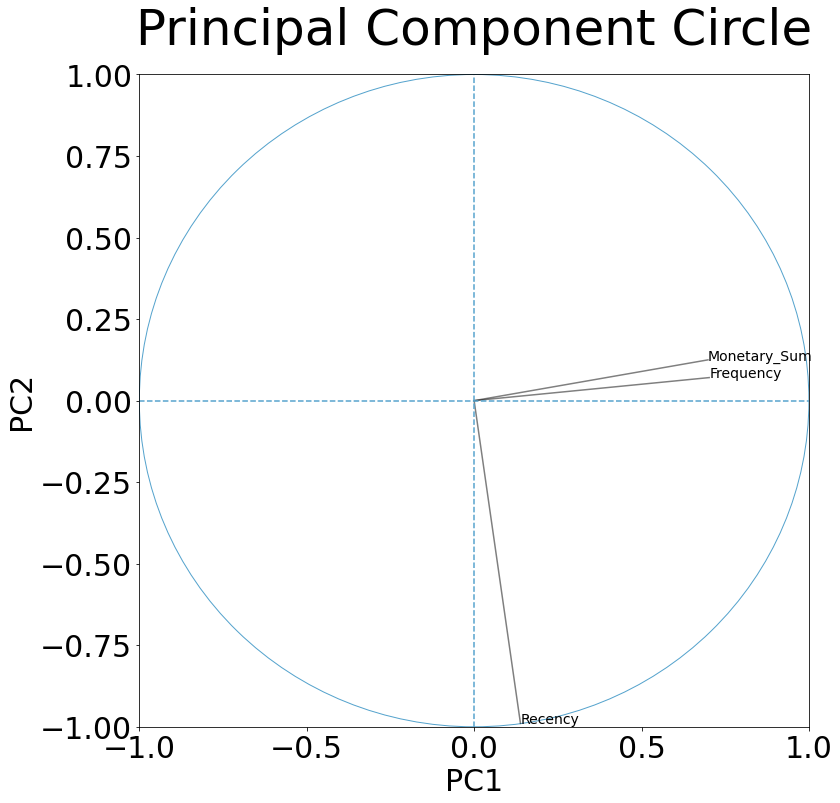

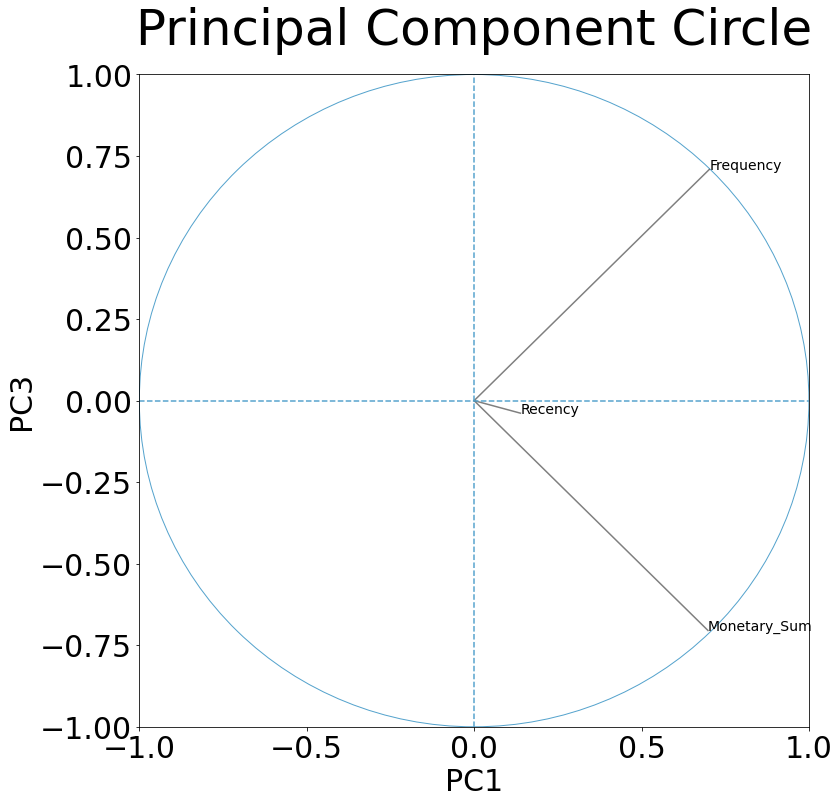

In [10]:
# Plots the correlation circles of the above PCA

# N.B : One can find above anchors to make back and forth analysis with
# projected data with clusters

plot_correlation_circle(X_std_pca.components_[0, :],
                        X_std_pca.components_[1, :],
                        X_std.columns,
                        'PC1',
                        'PC2')

plot_correlation_circle(X_std_pca.components_[0, :],
                        X_std_pca.components_[2, :],
                        X_std.columns,
                        'PC1',
                        'PC3')


<center><h3>Kmeans (chosen model in RFM)

In [11]:
# Creates an empty dataframe for computation logs

kmeans_scores_df = pd.DataFrame(data=[])

# Computes inertia, silhouette score and fit-time for k selection

# NB : The range is in a [3;9] range as k-clusters > 9 would be too much
# and < 3 not enough

for i in range(3, 10):

    t0 = time.time()

    kmeans = KMeans(n_clusters=i, random_state=seed)\
        .fit(X_std[rfm_selection])

    fit_time = time.time() - t0

    # Commits params and scores in kmeans_scores_df

    kmeans_scores_df.loc[i, 'clusters'] = i

    kmeans_scores_df.loc[i, 'inertia'] = kmeans.inertia_

    kmeans_scores_df.loc[i, 'silhouette'] = \
        silhouette_score(X_std, kmeans.labels_)

    kmeans_scores_df.loc[i, 'fit_time'] = fit_time


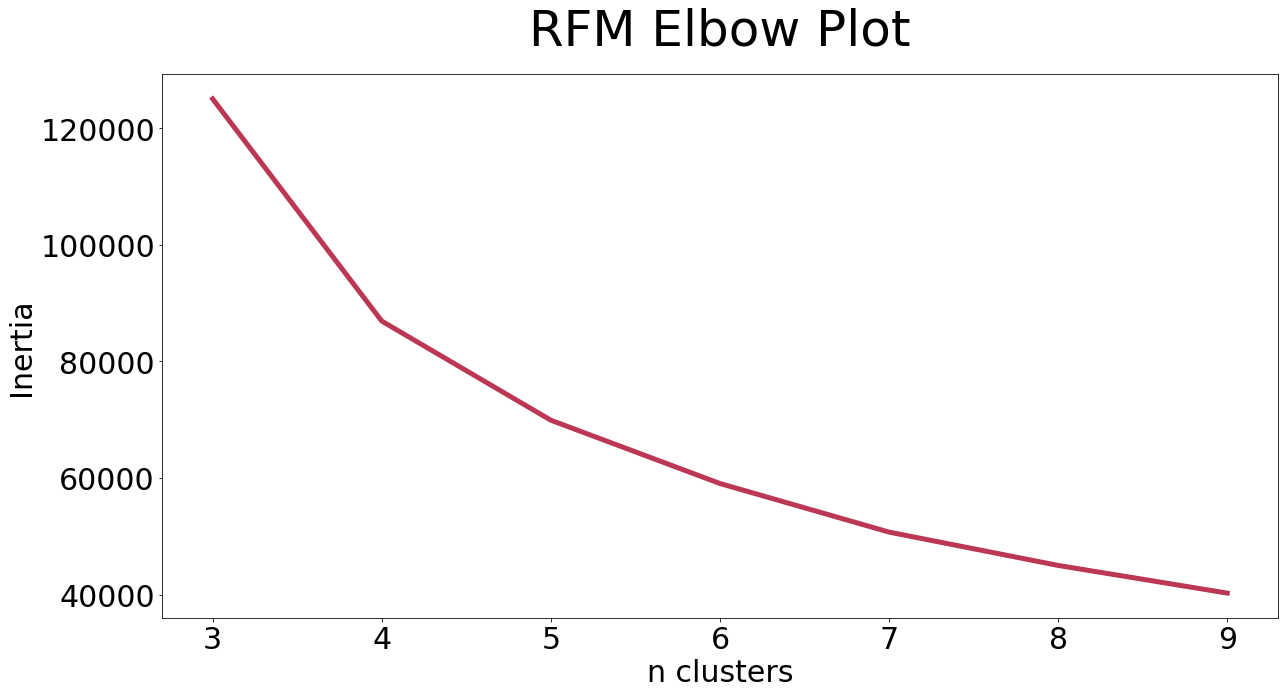

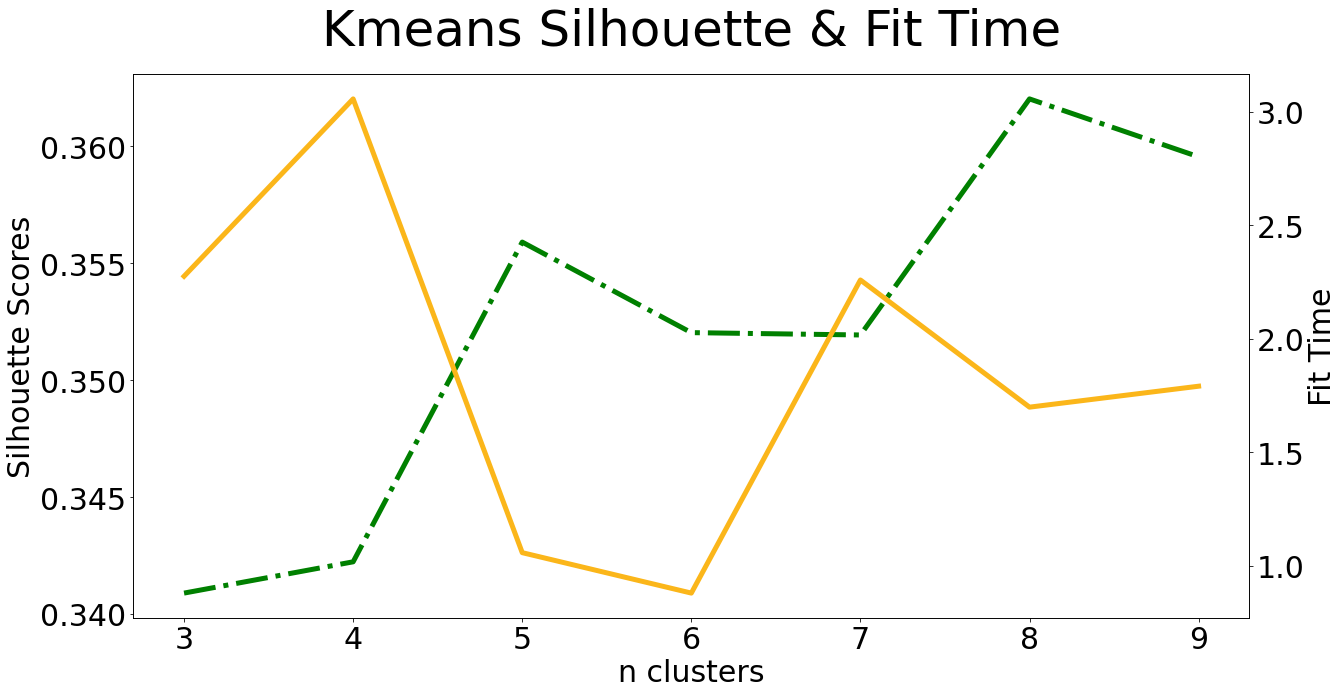

In [12]:
# Plots results

# Elbow Plot

fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=kmeans_scores_df,
             x='clusters',
             y='inertia',
             color=sns.color_palette('inferno', 5)[2],
             lw=5)

ax.tick_params(labelsize=tick_size)
ax.set_xlabel('n clusters', fontsize=text_size)
ax.set_ylabel('Inertia', fontsize=text_size)

plt.title('RFM Elbow Plot', fontsize=title_size, pad=30)
plt.show();


# Silhouette & Fit time plots

fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

sns.lineplot(data=kmeans_scores_df,
             x='clusters',
             y='silhouette',
             lw=5,
             color=sns.color_palette('inferno', 5)[4],
             ax=ax1)

sns.lineplot(data=kmeans_scores_df,
             x='clusters',
             y='fit_time',
             lw=5,
             color='green',
             ax=ax2,
             ls='dashdot')

ax1.set_zorder(1)
ax1.patch.set_visible(False)
ax1.tick_params(labelsize=tick_size)
ax2.tick_params(labelsize=tick_size)
ax1.set_xlabel('n clusters', fontsize=text_size)
ax1.set_ylabel('Silhouette Scores', fontsize=text_size)
ax2.set_ylabel('Fit Time', fontsize=text_size)
ax2.tick_params(labelsize=tick_size)
plt.title('Kmeans Silhouette & Fit Time', fontsize=title_size, pad=30)
plt.show();


In [13]:
# Fits a 4Means

kmeans_4 = KMeans(n_clusters=4, random_state=seed).fit(X_std[rfm_selection])

X_std['kmeans_labels'] = kmeans_4.labels_

X_std_pca_projected['kmeans_labels'] = X_std['kmeans_labels'].values


In [14]:
# Creates a dataframe with kmeans's centroids

X_std_centroids = \
    pd.DataFrame(kmeans_4.cluster_centers_,
                 columns=rfm_selection)

X_std_centroids['cluster'] = \
    X_std_centroids.index

X_std_centroids.head()


,Frequency,Recency,Monetary_Sum,cluster
0,-0.169459,0.816152,-0.543020,0
1,-0.169459,-0.993496,-0.353773,1
2,5.524970,0.108197,0.912638,2
3,-0.169459,0.198010,1.174970,3


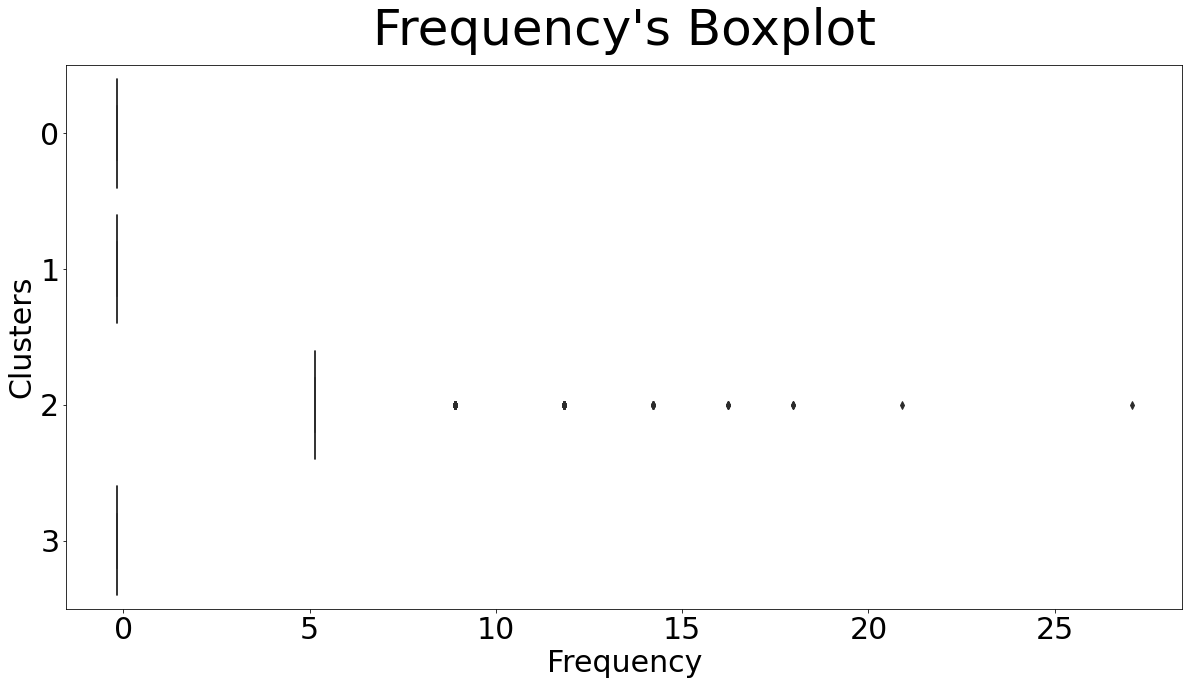

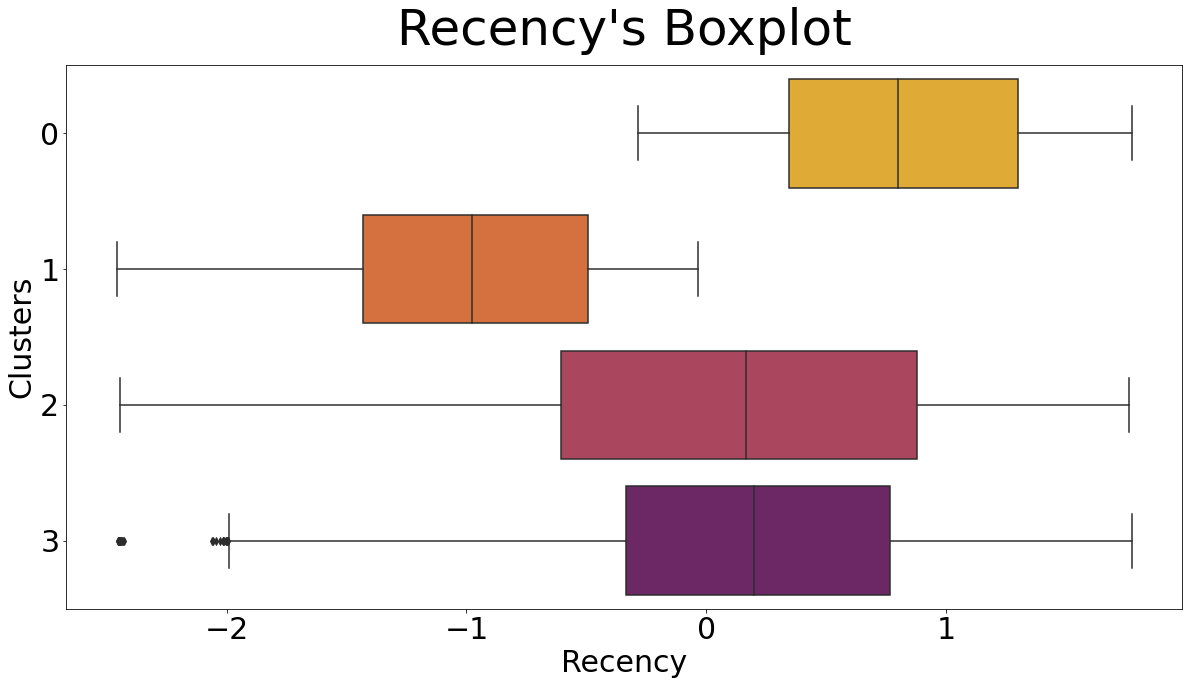

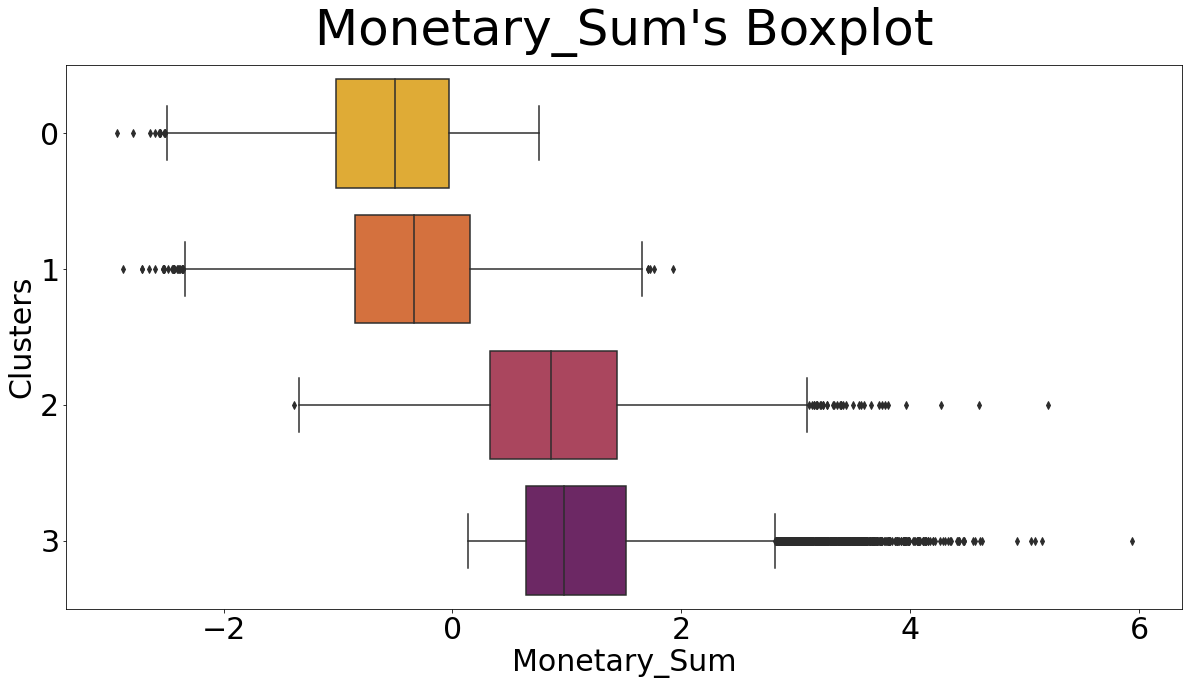

In [15]:
# Plots cluster's boxplots

for i in rfm_selection:
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.boxplot(data=X_std[rfm_selection + ['kmeans_labels']],
                x=i,
                y='kmeans_labels',
                palette=palette_max_5,
                orient="h",
                ax=ax)
    ax.tick_params(labelsize=tick_size)
    ax.set_xlabel('{}'.format(i), fontsize=text_size)
    ax.set_ylabel('Clusters', fontsize=text_size)
    plt.title('{}\'s Boxplot'.format(i), pad=20, fontsize=title_size)
plt.show();


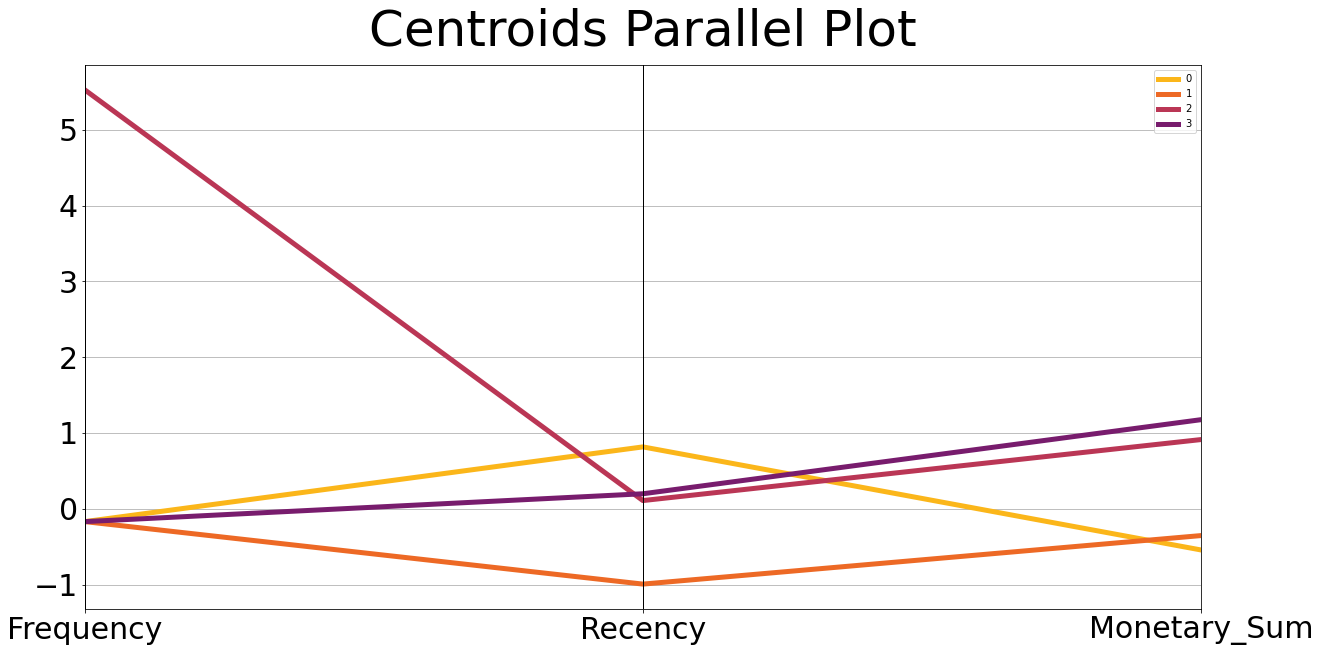

In [16]:
# Parrallel plots the centroids of the 4Means

fig, ax = plt.subplots(figsize=(20, 10))

parallel_coordinates(X_std_centroids,
                     'cluster',
                     color=palette_max_5.values(),
                     ax=ax,
                     lw=5)

ax.tick_params(labelsize=tick_size)

plt.title('Centroids Parallel Plot', pad=20, fontsize=title_size)
plt.show();


* [Anchor to PCA Circles](#PCA_Circles)


<p class="anchor" id="PCA_Kmeans"></p>

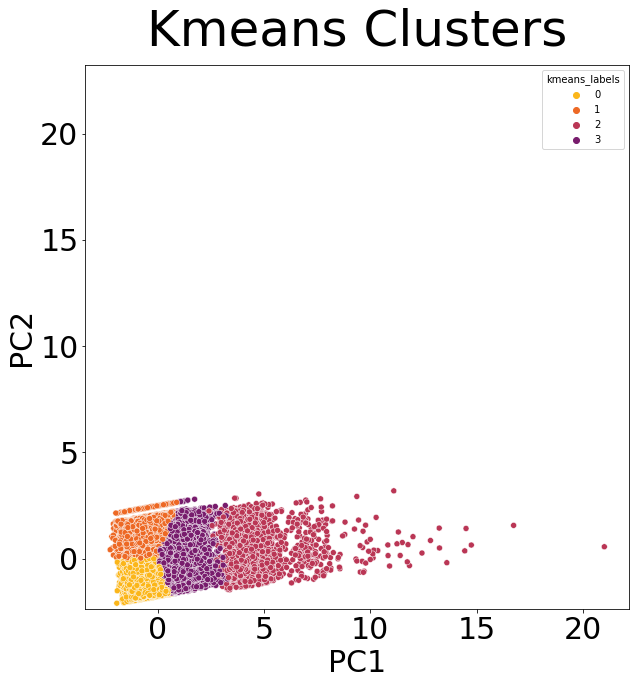

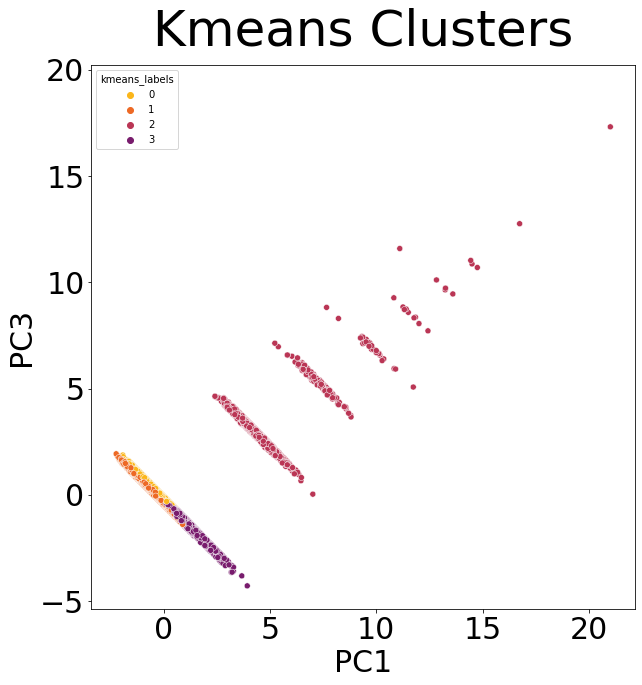

In [17]:
# Plots PCA projections with clusters hued

# Plots PC1 against PC2

fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(
    data=X_std_pca_projected[components_name + ['kmeans_labels']],
    x='PC1',
    y='PC2',
    hue='kmeans_labels',
    palette=palette_max_5,
    ax=ax)

ax.tick_params(labelsize=tick_size)
ax.set_xlabel('PC1', fontsize=text_size)
ax.set_ylabel('PC2', fontsize=text_size)

plt.axis('square')

plt.title('Kmeans Clusters', pad=20, fontsize=title_size)

plt.show();

# Plots PC1 against PC3

fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(
    data=X_std_pca_projected[components_name + ['kmeans_labels']],
    x='PC1',
    y='PC3',
    hue='kmeans_labels',
    palette=palette_max_5,
    ax=ax)

ax.tick_params(labelsize=tick_size)
ax.set_xlabel('PC1', fontsize=text_size)
ax.set_ylabel('PC3', fontsize=text_size)

plt.axis('square')

plt.title('Kmeans Clusters', pad=20, fontsize=title_size)

plt.show();


<center><h6>Kmeans interpretation

In [18]:
# Creates a dataframe for interpretation and possible marketing
# actionability

interpretation = {
    'Cluster': [1, 0, 2, 3],
    'Frequency': ['★☆☆☆☆', '★☆☆☆☆', '★★★★★', '★☆☆☆☆'],
    'Recency': ['★☆☆☆☆', '★★★★★', '★★★☆☆', '★★★☆☆'],
    'Monetary_Sum': ['★☆☆☆☆', '★☆☆☆☆', '★★★★☆', '★★★★★'],
    'Catchphrase': ['I am not recent and I did\'t spent a lot !',
                    'I am  recent and I don\'t spend a lot !',
                    'I am loyal, therefore I spend a lot !',
                    'I spend a lot ! '],
    'Marketing Operation Example': ['Recovery Campaign',
                                    'Customer Loyalty Building Campaign',
                                    'Loyalty/Reward Campaign',
                                    'Low frequency high range '
                                    + 'product Campaign']}

with pd.option_context('display.max_colwidth', None):
    pd.DataFrame(interpretation)


,Cluster,Frequency,Recency,Monetary_Sum,Catchphrase,Marketing Operation Example
0,1,★☆☆☆☆,★☆☆☆☆,★☆☆☆☆,I am not recent and I did't spent a lot !,Recovery Campaign
1,0,★☆☆☆☆,★★★★★,★☆☆☆☆,I am recent and I don't spend a lot !,Customer Loyalty Building Campaign
2,2,★★★★★,★★★☆☆,★★★★☆,"I am loyal, therefore I spend a lot !",Loyalty/Reward Campaign
3,3,★☆☆☆☆,★★★☆☆,★★★★★,I spend a lot !,Low frequency high range product Campaign


<center><h3>Other Models (not chosen)

<center><h3>DBSCAN

In [19]:
# Creates an empty dataframe for computation logs

dbscan_scores_df = pd.DataFrame(data=[])

dbscan_grid = [{'eps': [0.5, 1],
               'min_samples': [50, 100]}]

# Computes DBSCAN sihlouette score and fit time according to
# different combinaison of parameters (outputed)
# NB : The number of clusters found by the DBSCAN is also retrieved

for i, params in enumerate(ParameterGrid(dbscan_grid)):

    dbscan = DBSCAN()

    dbscan.set_params(**params)

    dbscan_scores_df.loc[i, 'eps'] = params['eps']
    dbscan_scores_df.loc[i, 'min_samples'] = params['min_samples']

    t0 = time.time()

    dbscan_fitted = dbscan.fit(X_std[rfm_selection])

    fit_time = time.time() - t0

    dbscan_scores_df.loc[i, 'clusters'] = len(np.unique(dbscan_fitted.labels_))

    dbscan_scores_df.loc[i, 'silhouette'] = \
        silhouette_score(X_std, dbscan_fitted.labels_)

    dbscan_scores_df.loc[i, 'fit_time'] = fit_time


DBSCAN(min_samples=50)

DBSCAN(min_samples=100)

DBSCAN(eps=1, min_samples=50)

DBSCAN(eps=1, min_samples=100)

In [20]:
# Analyses the clusters when they are in the [3;9] range (for actionability)

dbscan_scores_df[(dbscan_scores_df['clusters'] > 2)
                 & (dbscan_scores_df['clusters'] < 10)]\
    .style\
    .highlight_max(subset=['silhouette'], color='#fbb61a')\
    .highlight_min(subset=['fit_time'], color='#fbb61a')


# Displays the chosen cluster number, silhouette and
# fit_time relation for DBSCAN

dbscan_scores_df.loc[[1]]


,eps,min_samples,clusters,silhouette,fit_time
0,0.500000,50.000000,3.000000,0.603677,21.935313
1,0.500000,100.000000,3.000000,0.601274,21.571065
2,1.000000,50.000000,4.000000,0.604234,49.620920
3,1.000000,100.000000,3.000000,0.606150,51.523329


,eps,min_samples,clusters,silhouette,fit_time
1,0.5,100.0,3.0,0.601274,21.571065


In [21]:
# Fit the chosen params

dbscan_3 = DBSCAN(eps=0.5, min_samples=100).fit(X_std[rfm_selection])

X_std['dbscan_labels'] = dbscan_3.labels_

# Changes -1 labels in max + 1 for easiness of use

X_std['dbscan_labels'] = \
    X_std['dbscan_labels']\
    .apply(lambda x: X_std['dbscan_labels'].max() + 1 if x == -1 else x)

X_std_pca_projected['dbscan_labels'] = X_std['dbscan_labels'].values


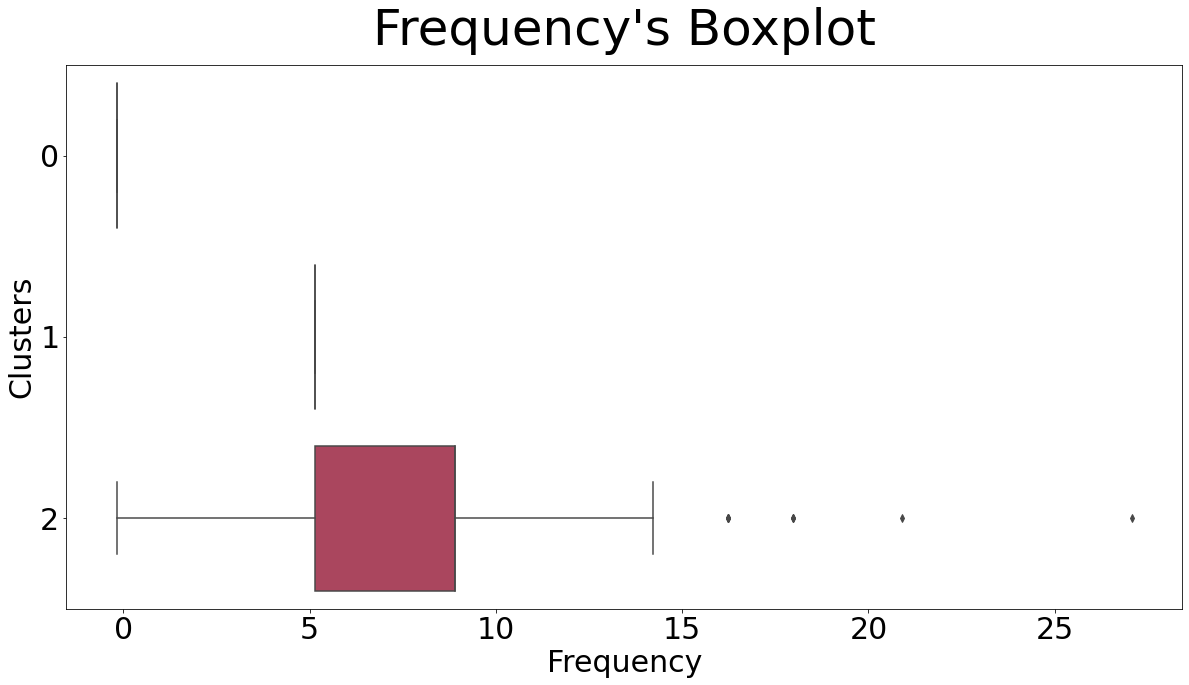

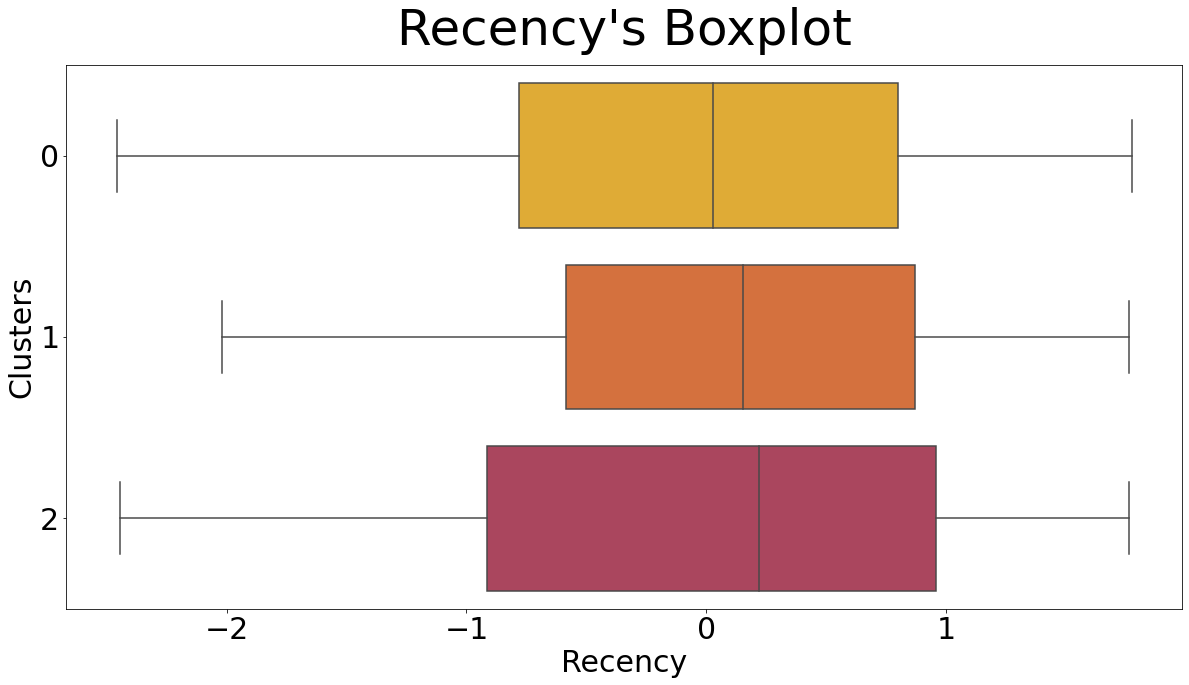

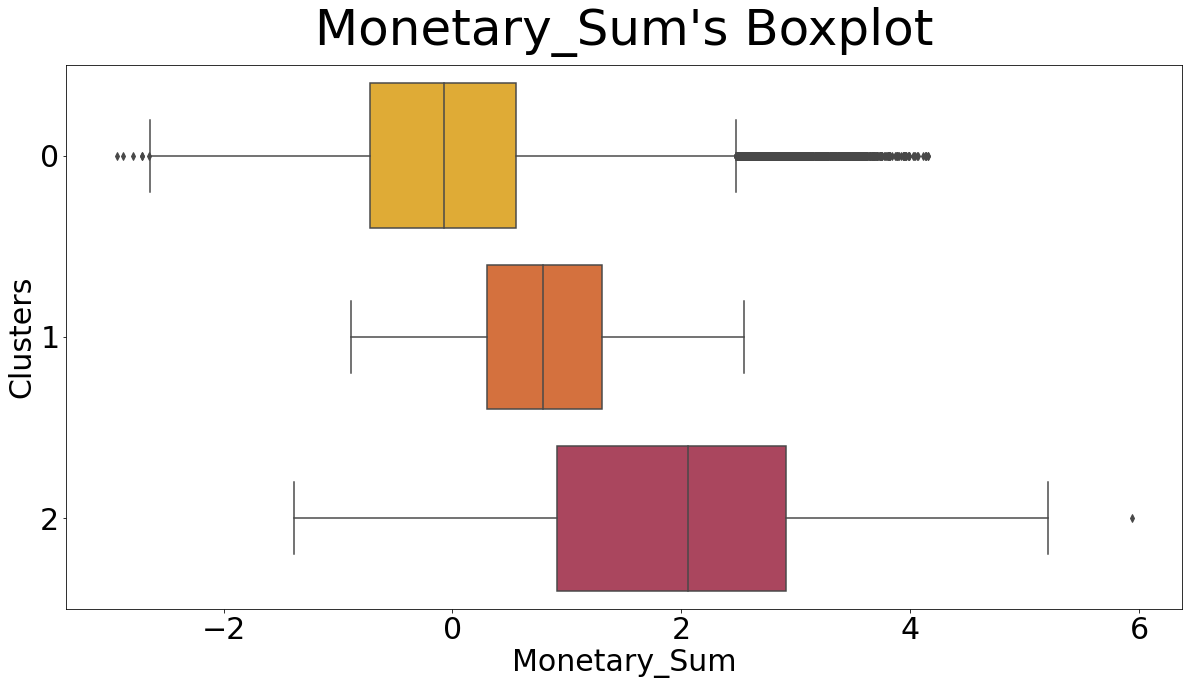

In [22]:
# Plots cluster's boxplots

for i in rfm_selection:

    fig, ax = plt.subplots(figsize=(20, 10))

    sns.boxplot(data=X_std[rfm_selection + ['dbscan_labels']],
                x=i,
                y='dbscan_labels',
                palette=palette_max_5,
                orient="h",
                ax=ax)

    ax.tick_params(labelsize=tick_size)
    ax.set_xlabel('{}'.format(i), fontsize=text_size)
    ax.set_ylabel('Clusters', fontsize=text_size)
    plt.title('{}\'s Boxplot'.format(i), pad=20, fontsize=title_size)

plt.show();


* [Anchor to PCA Circles](#PCA_Circles)


<p class="anchor" id="PCA_DBSCAN"></p>

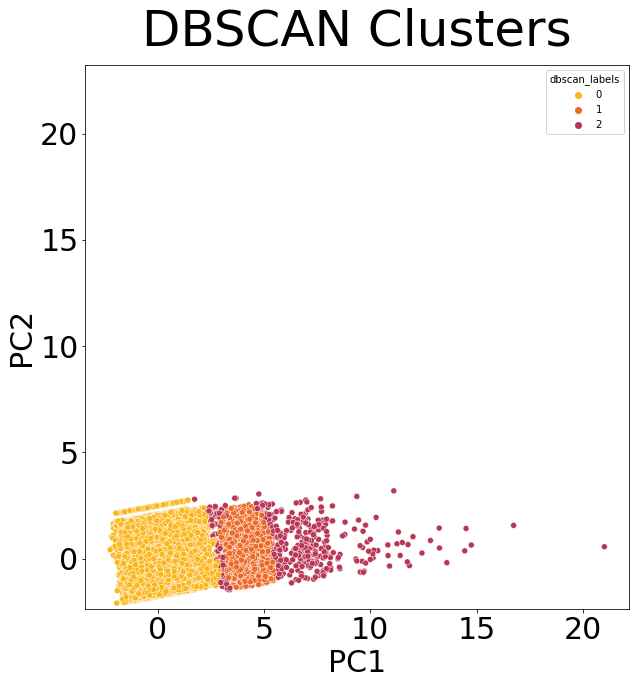

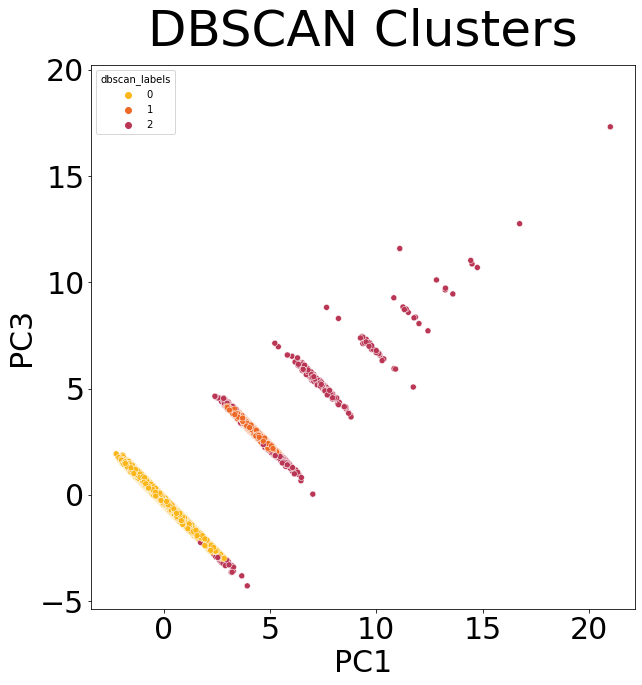

In [23]:
# Plots PCA projections with clusters hued

# Plots PC1 against PC2

fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(
    data=X_std_pca_projected[components_name + ['dbscan_labels']],
    x='PC1',
    y='PC2',
    hue='dbscan_labels',
    palette=palette_max_5,
    ax=ax)

ax.tick_params(labelsize=tick_size)
ax.set_xlabel('PC1', fontsize=text_size)
ax.set_ylabel('PC2', fontsize=text_size)

plt.axis('square')

plt.title('DBSCAN Clusters', pad=20, fontsize=title_size)

plt.show();

# Plots PC1 against PC3

fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(
    data=X_std_pca_projected[components_name + ['dbscan_labels']],
    x='PC1',
    y='PC3',
    hue='dbscan_labels',
    palette=palette_max_5,
    ax=ax)

ax.tick_params(labelsize=tick_size)
ax.set_xlabel('PC1', fontsize=text_size)
ax.set_ylabel('PC3', fontsize=text_size)

plt.axis('square')

plt.title('DBSCAN Clusters', pad=20, fontsize=title_size)

plt.show();


<center><h3>Hierarchical Clustering

In [24]:
# Put a cutoff for aglomerative clustering as it is time consuming in a
# new dataframe (X_std_agglomerative_clustering)

agglomerative_clustering_cutoff = 9999

X_std_agglomerative_clustering = \
    X_std.iloc[:agglomerative_clustering_cutoff].copy()

# Creates an empty dataframe for computation logs

agglomerative_clustering_df = pd.DataFrame(data=[])

# Computes the silhouette score and the fit-time for clusters
# in the range [3;9]

for i in range(3, 10):

    t0 = time.time()

    agglomerative_clustering = \
        AgglomerativeClustering(n_clusters=i)\
        .fit(X_std_agglomerative_clustering[rfm_selection])

    fit_time = time.time() - t0

    # Commits params and scores in agglomerative_clustering_df

    agglomerative_clustering_df.loc[i, 'clusters'] = i

    agglomerative_clustering_df.loc[i, 'silhouette'] = \
        silhouette_score(X_std_agglomerative_clustering,
                         agglomerative_clustering.labels_)

    agglomerative_clustering_df.loc[i, 'fit_time'] = fit_time


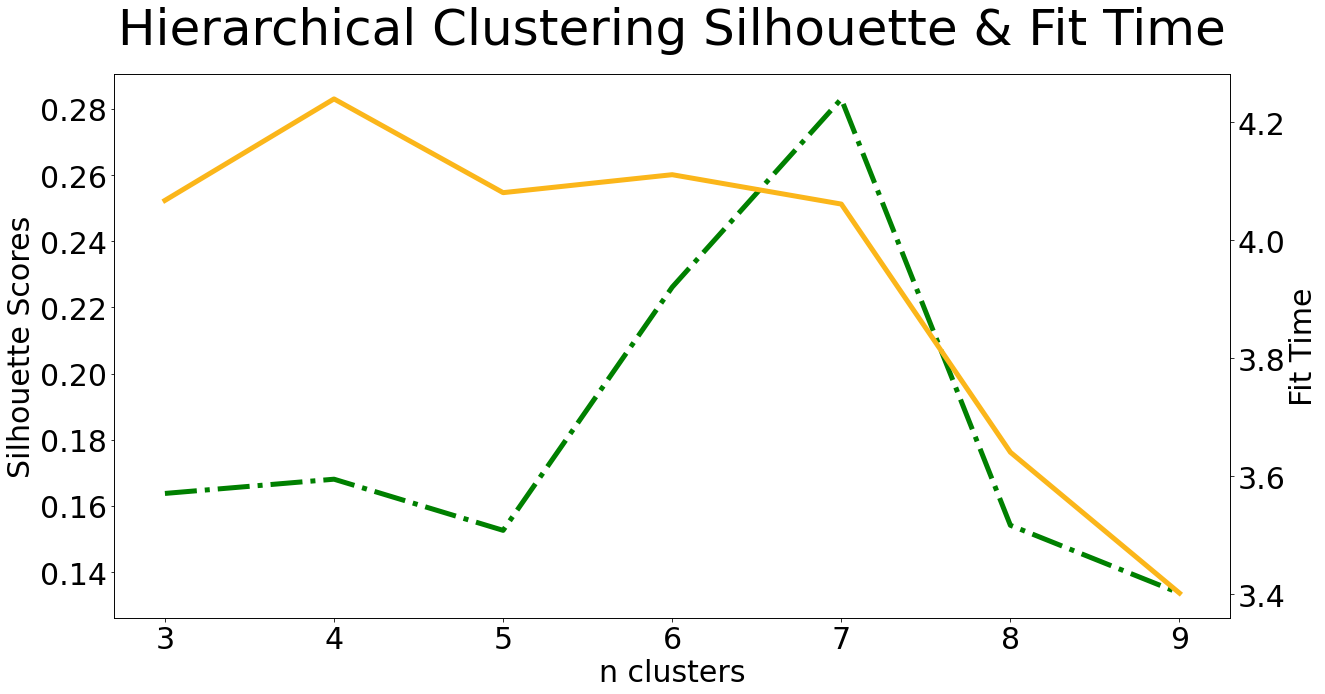

In [25]:
# Silhouette & Fit time plots

fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

sns.lineplot(data=agglomerative_clustering_df,
             x='clusters',
             y='silhouette',
             lw=5,
             color=sns.color_palette('inferno', 5)[4],
             ax=ax1)

sns.lineplot(data=agglomerative_clustering_df,
             x='clusters',
             y='fit_time',
             lw=5,
             color='green',
             ax=ax2,
             ls='dashdot')

ax1.set_zorder(1)
ax1.patch.set_visible(False)
ax1.tick_params(labelsize=tick_size)
ax1.set_xlabel('n clusters', fontsize=text_size)
ax1.set_ylabel('Silhouette Scores', fontsize=text_size)

ax2.set_ylabel('Fit Time', fontsize=text_size)
ax2.tick_params(labelsize=tick_size)

plt.title('Hierarchical Clustering Silhouette & Fit Time',
          fontsize=title_size, pad=30)
plt.show();


In [26]:
# Fits a hierarchical clustering with 4 clusters

agglomerative_clustering_4 = \
    AgglomerativeClustering(n_clusters=4)\
    .fit(X_std_agglomerative_clustering[rfm_selection])

X_std_agglomerative_clustering['agglomerative_clustering_labels'] = \
    agglomerative_clustering_4.labels_

# Adapts the PCA projection to the cutoff for agglomerative clustering

X_std_pca_projected.loc[:agglomerative_clustering_cutoff - 1,
                        'agglomerative_clustering_labels'] = \
    agglomerative_clustering_4.labels_


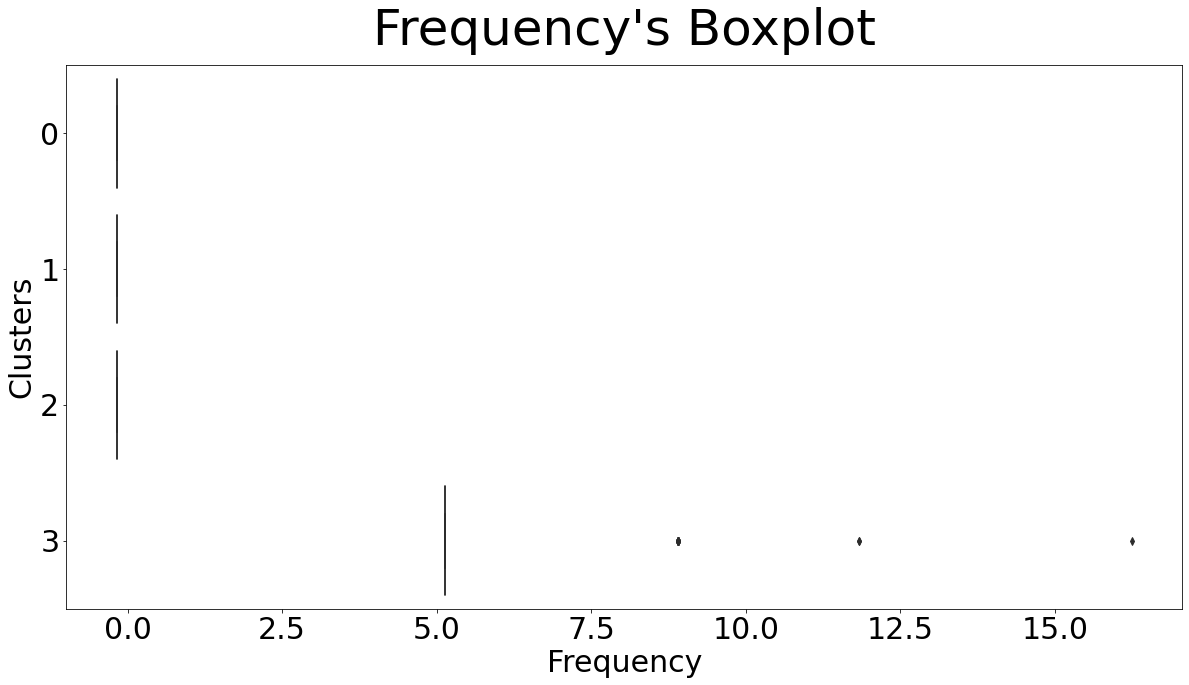

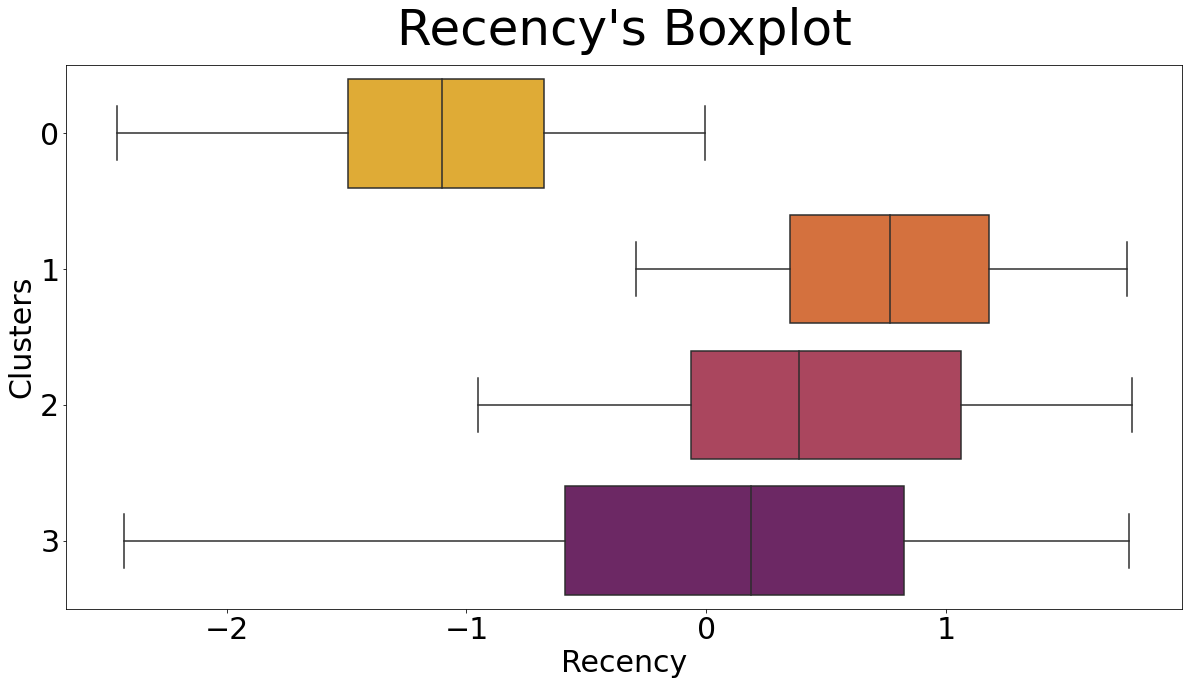

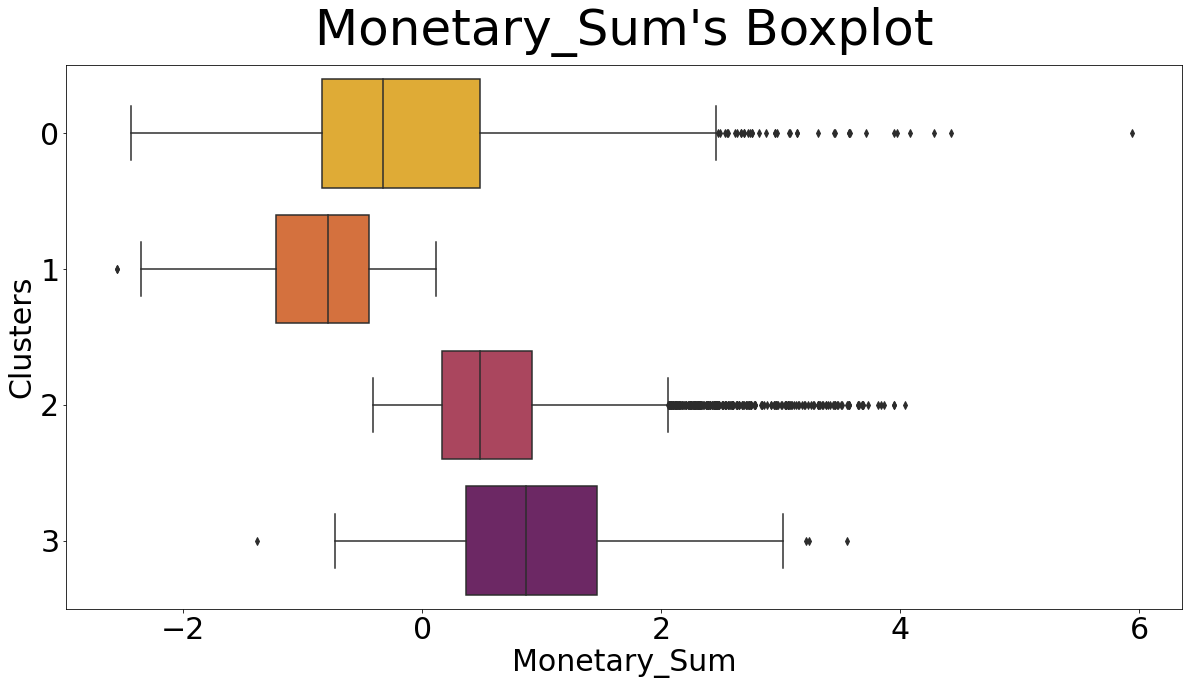

In [27]:
# Plots cluster's boxplots

for i in rfm_selection:

    fig, ax = plt.subplots(figsize=(20, 10))

    sns.boxplot(data=X_std_agglomerative_clustering[
                     rfm_selection + ['agglomerative_clustering_labels']],
                x=i,
                y='agglomerative_clustering_labels',
                palette=palette_max_5,
                orient="h",
                ax=ax)

    ax.tick_params(labelsize=tick_size)
    ax.set_xlabel('{}'.format(i), fontsize=text_size)
    ax.set_ylabel('Clusters', fontsize=text_size)
    plt.title('{}\'s Boxplot'.format(i), pad=20, fontsize=title_size)
plt.show();


* [Anchor to PCA Circles](#PCA_Circles)


<p class="anchor" id="PCA_hierarchical"></p>

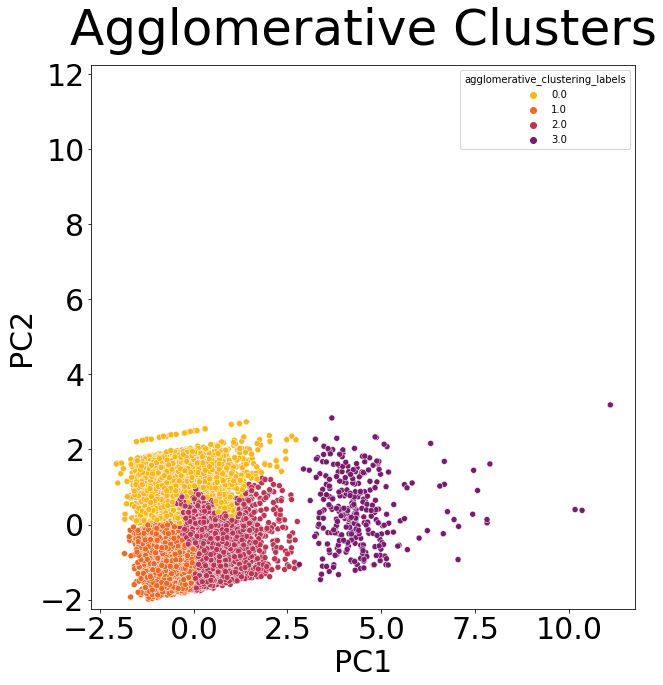

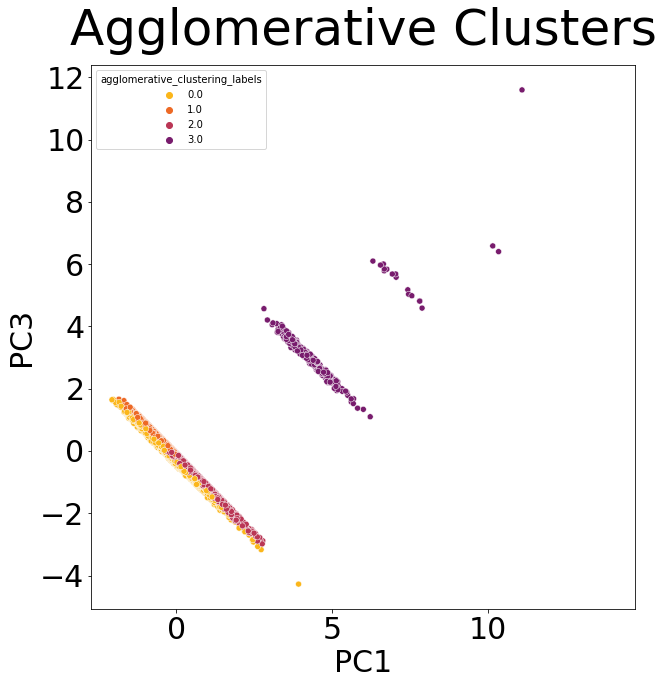

In [28]:
# Plots PCA projections with clusters hued

# Plots PC1 against PC2

fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(
    data=X_std_pca_projected.loc[:agglomerative_clustering_cutoff,
                                 components_name
                                 + ['agglomerative_clustering_labels']],
    x='PC1',
    y='PC2',
    hue='agglomerative_clustering_labels',
    palette=palette_max_5,
    ax=ax)

ax.tick_params(labelsize=tick_size)
ax.set_xlabel('PC1', fontsize=text_size)
ax.set_ylabel('PC2', fontsize=text_size)

plt.axis('square')

plt.title('Agglomerative Clusters', pad=20, fontsize=title_size)

plt.show();

# Plots PC1 against PC3

fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(
    data=X_std_pca_projected.loc[:agglomerative_clustering_cutoff,
                                 components_name
                                 + ['agglomerative_clustering_labels']],
    x='PC1',
    y='PC3',
    hue='agglomerative_clustering_labels',
    palette=palette_max_5,
    ax=ax)

ax.tick_params(labelsize=tick_size)
ax.set_xlabel('PC1', fontsize=text_size)
ax.set_ylabel('PC3', fontsize=text_size)

plt.axis('square')

plt.title('Agglomerative Clusters', pad=20, fontsize=title_size)

plt.show();
